In [2]:
import datetime
import os
import yaml

import numpy as np
import pandas as pd

In [5]:
ENV_FILE = '../env.yaml'
with open(ENV_FILE) as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

# Initialisation des chemins vers les fichiers
ROOT_DIR = os.path.dirname(os.path.abspath(ENV_FILE))
DATA_FILE = os.path.join(ROOT_DIR, 
                         params['directories']['processed'], 
                         params['files']['all_data'])

# Lecture du fichiers des données
epidemie_df = (pd.read_csv(DATA_FILE, parse_dates=["Last Update"])
               .assign(day=lambda _df: _df['Last Update'].dt.date)
               .drop_duplicates(subset=['Country/Region', 'Province/State', 'day'])
               [lambda df: df.day <= datetime.date(2020, 3, 12)]
              )

In [9]:
france_df = (epidemie_df[epidemie_df['Country/Region'] == 'France']
             .groupby(['Country/Region', 'day'])
             .agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})
             .reset_index()
            )

france_df.tail()

,Country/Region,day,Confirmed,Deaths,Recovered
23,France,2020-03-07,949.0,11.0,12.0
24,France,2020-03-08,1126.0,19.0,12.0
25,France,2020-03-09,1209.0,19.0,12.0
26,France,2020-03-10,1784.0,33.0,12.0
27,France,2020-03-11,2287.0,48.0,12.0


- S : Susceptible
- I : Infected
- R : Recovered

In [14]:
france_df = (epidemie_df[epidemie_df['Country/Region'] == 'France']
             .groupby(['Country/Region', 'day'])
             .agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})
             .reset_index()
            )

france_df.tail()

,Country/Region,day,Confirmed,Deaths,Recovered
23,France,2020-03-07,949.0,11.0,12.0
24,France,2020-03-08,1126.0,19.0,12.0
25,France,2020-03-09,1209.0,19.0,12.0
26,France,2020-03-10,1784.0,33.0,12.0
27,France,2020-03-11,2287.0,48.0,12.0


In [30]:
def get_country(self, country):
    return(epidemie_df[epidemie_df['Country/Region'] == country]
           .groupby(['Country/Region', 'day'])
           .agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})
           .reset_index()
          )

# Monkey patch pd.DataFrame
pd.DataFrame.get_country = get_country

In [31]:
italy_df = epidemie_df.get_country('Italy')

In [33]:
korea_df = get_country(epidemie_df, 'South Korea')
korea_df.tail()

# epidemie_df.get_country('South Korea').head()

,Country/Region,day,Confirmed,Deaths,Recovered
38,South Korea,2020-03-05,6088.0,35.0,41.0
39,South Korea,2020-03-06,6593.0,42.0,135.0
40,South Korea,2020-03-07,7041.0,44.0,135.0
41,South Korea,2020-03-08,7314.0,50.0,118.0
42,South Korea,2020-03-09,7478.0,53.0,118.0


In [34]:
korea_df['infected'] = korea_df['Confirmed'].diff()
italy_df['infected'] = italy_df['Confirmed'].diff()

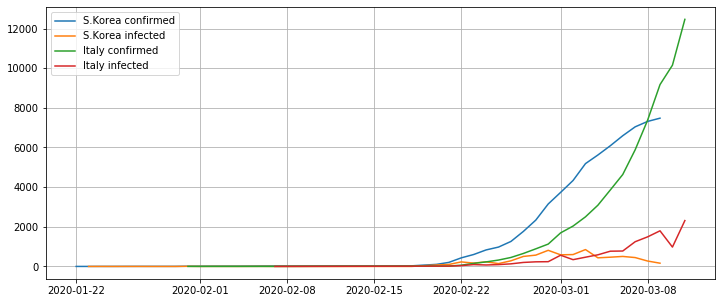

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(12, 5))
plt.plot(korea_df.day, korea_df.Confirmed, label='S.Korea confirmed');
plt.plot(korea_df.day, korea_df.infected, label='S.Korea infected');
plt.plot(italy_df.day, italy_df.Confirmed, label='Italy confirmed');
plt.plot(italy_df.day, italy_df.infected, label='Italy infected');
plt.grid(True)
plt.legend()
plt.show()

In [39]:
def SIR(t,y):
    S = y[0]
    I = y[1]
    R = y[2]
    return([-beta*S*I, beta*S*I-gamma*I, gamma*I])

In [44]:
korea_df.loc[2:].head()

,Country/Region,day,Confirmed,Deaths,Recovered,infected
2,South Korea,2020-01-24,2.0,0.0,0.0,1.0
3,South Korea,2020-01-25,2.0,0.0,0.0,0.0
4,South Korea,2020-01-26,3.0,0.0,0.0,1.0
5,South Korea,2020-01-27,4.0,0.0,0.0,1.0
6,South Korea,2020-01-28,4.0,0.0,0.0,0.0


In [45]:
from scipy.integrate import solve_ivp

beta, gamma = [0.01, 0.1]
solution_korea = solve_ivp(SIR, [0, 40], [51_470_000, 1, 0], t_eval=np.arange(0, 40, 1))

In [53]:
solution_korea

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 10617824
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])
 t_events: None
        y: array([[ 5.14700000e+07,  2.04872617e-07, -5.79192642e-07,
        -1.02864803e-07,  3.39434814e-07,  1.95092383e-07,
         1.56908982e-06, -5.54756490e-07,  8.55639764e-07,
        -3.84005541e-07,  1.14854677e-06,  1.04737837e-06,
         1.41446345e-07, -3.89979213e-08, -1.31579840e-06,
        -1.17991062e-06, -5.32379870e-07,  6.79204480e-07,
        -7.21960552e-07, -4.83684927e-07, -5.40636688e-07,
         5.00739636e-09, -2.42491836e-07, -4.15623310e-07,
         5.38168115e-07, -1.20506229e-08,  4.33030631e-07,
        -5.17489767e-07,  6.52063146e-07, -1.73762585e-07,
         6.151133

In [79]:
def plot_epidemia(solution, infected):
    fig = plt.figure(figsize=(12, 5))
    plt.plot(solution.t, solution.y[0])
    plt.plot(solution.t, solution.y[1])
    plt.plot(solution.t, solution.y[2])
    plt.plot(infected.reset_index(drop=True).index, infected, "k*:")
    plt.grid("True")
    if susceptible:
        plt.legend(["Susceptible", "Infected", "Recovered", "Original Data"])
    else:
        plt.legend(["Infected", "Recovered", "Original Data"])
    plt.show()

NameError: name 'Susceptible' is not defined

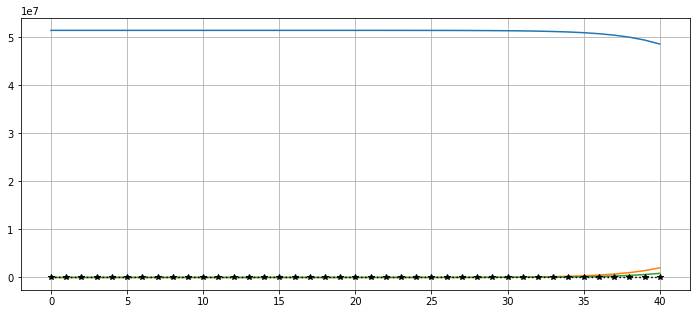

In [80]:
plot_epidemia(solution_korea, korea_df.loc[2:]['infected'])

### Approximation

In [54]:
korea_df['infected'].diff().max()

252.0

In [59]:
(korea_df['Recovered'].diff().loc[korea_df['infected'] != 0]/korea_df['infected'].loc[korea_df['infected'] != 0]).mean()

0.17870945831971552

In [60]:
beta, gamma = [0.00000001, 0.15]
solution_korea = solve_ivp(SIR, [0, 40], [51_470_000, 1, 0], t_eval=np.arange(0, 41, 1))

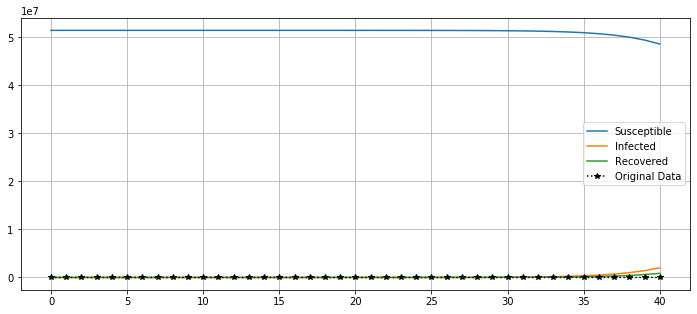

In [61]:
plot_epidemia(solution_korea, korea_df.loc[2:]['infected'])

In [62]:
solution_korea.y[1][::5]

array([1.00000000e+00, 6.19284267e+00, 3.83453161e+01, 2.37554158e+02,
       1.47071922e+03, 9.09598386e+03, 5.62166711e+04, 3.44431562e+05,
       1.99429869e+06])

In [69]:
def sumsq_error(parameters):
    beta, gamma = parameters
    def SIR(t,y):
        S = y[0]
        I = y[1]
        R = y[2]
        return([-beta*S*I, beta*S*I-gamma*I, gamma*I])
    
    solution = solve_ivp(SIR, [0, nb_steps-1], [total_population, 1, 0], t_eval=np.arange(0, nb_steps, 1))
    
    return(sum((solution.y[1]-infected_population)**2))

In [70]:
total_population = 51_470_000
infected_population = korea_df.loc[2:]['infected']
nb_steps = len(infected_population)

In [83]:
%%time

from scipy.optimize import minimize

msol = minimize(sumsq_error, [0.001, 0.1], method='Nelder-Mead')
msol.x

Wall time: 10min 53s


array([ 0.06321101, 33.06340503])

In [72]:
beta_optimal = 5.67e-3
gamma_optimal = 24.7 

In [73]:
beta = beta_optimal
gamma = gamma_optimal
solution_korea_optimal = solve_ivp(SIR, [0, 40], [51_470_000, 1, 0], t_eval=np.arange(0, 40, 1))

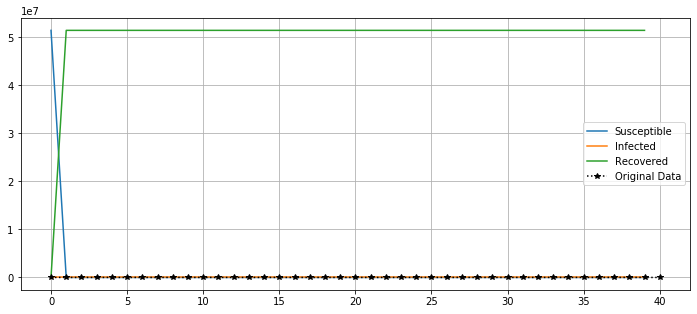

In [75]:
plot_epidemia(solution_korea_optimal, korea_df.loc[2:]['infected'])

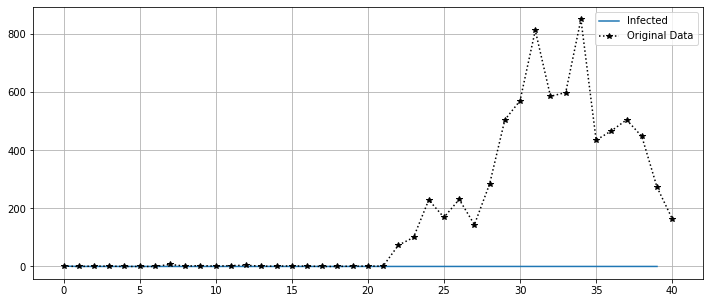

In [82]:
fig = plt.figure(figsize=(12, 5))
plt.plot(solution_korea_optimal.t, solution_korea_optimal.y[1])
plt.plot(korea_df.loc[2:]['infected'].reset_index(drop=True).index, korea_df.loc[2:]['infected'], "k*:")
plt.grid("True")
plt.legend(['Infected', "Original Data"])
plt.show()

In [85]:
china_df = epidemie_df.get_country('Mainland China')[:49]

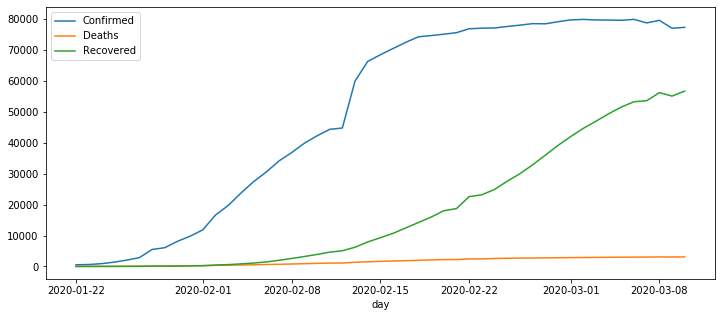

In [86]:
china_df.set_index('day').plot.line(figsize=(12,5))

In [87]:
beta, gamma = [0.001, 0.1]
china_df['infected'] = china_df['Confirmed'].diff()
nb_steps = china_df.shape[0]
solution_china = solve_ivp(SIR, [0, 40], [1_350_470_000, 1, 0], t_eval=np.arange(0, 41, 1))

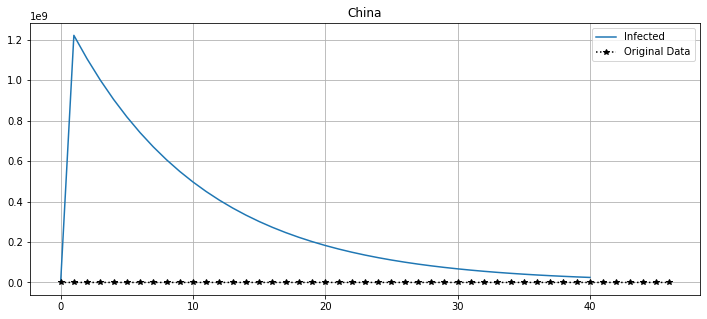

In [88]:
fig = plt.figure(figsize=(12, 5))
plt.plot(solution_china.t, solution_china.y[1])
plt.plot(china_df.loc[2:]['infected'].reset_index(drop=True).index, china_df.loc[2:]['infected'], "k*:")
plt.title('China')
plt.grid("True")
plt.legend(['Infected', "Original Data"])
plt.show()

In [89]:
# Limite modèle SIR: pas exacte d'esposer toute la population du pays au virus.
# Prendre 10% de la population